In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn import preprocessing
from keras import regularizers
import random
from keras.utils.vis_utils import plot_model
import time
from IPython.display import Image


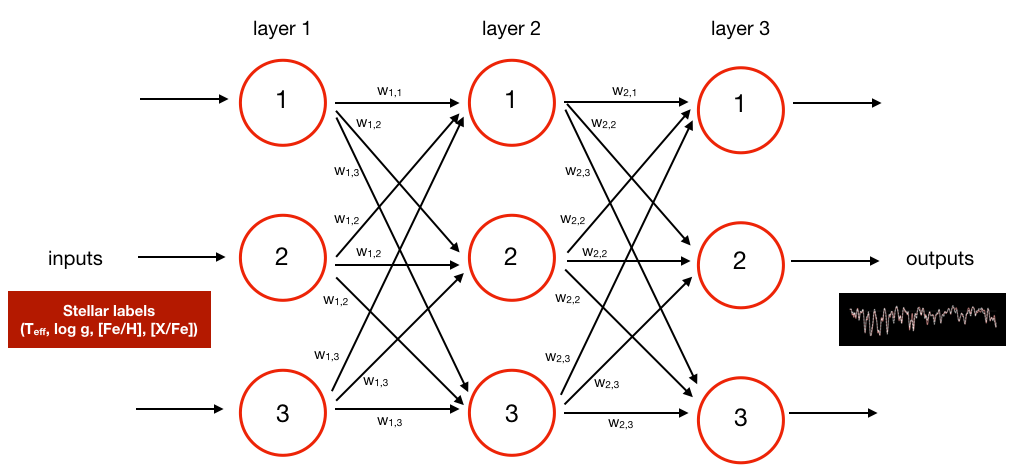

In [74]:
Image(filename='fig.png')


## Read stellar labels (input) and synthetic spectra (output)

In [75]:
labels = pd.read_csv('X_models.csv')
spectra = np.loadtxt("y_RVS.csv", delimiter=',')
spectra = spectra[:,1:spectra.shape[1]-1]


In [76]:
labels.head()

runID    teff      logg       feH      vmic     vbroad  \
0  1000000000000000000  6218.0  4.619077 -0.910052  2.605483   8.816360   
1  1000000000000000001  6254.0  4.664552 -0.289723  0.610352  18.323620   
2  1000000000000000002  5005.0  3.627608  0.576484  0.913904  28.404045   
3  1000000000000000003  3245.0  0.438310 -1.283513  2.452431  24.500015   
4  1000000000000000004  4282.0  0.718020 -0.749160  2.511468  18.305674   

       sife      cafe      tife      mgfe      ndfe       sfe      zrfe  \
0  0.418184  0.459938  0.119170  0.434419  0.480405 -0.123946  0.191479   
1 -0.141154 -0.044178  0.394487  0.067355  0.060857 -0.052785  0.060776   
2  0.360096  0.126649 -0.296405  0.330141  0.446568  0.149643 -0.229689   
3  0.210533 -0.069649 -0.401775 -0.162500 -0.300793 -0.254474 -0.277514   
4 -0.152219 -0.257944 -0.277805 -0.229354 -0.449344 -0.251708 -0.331349   

        nfe      crfe      cefe      nife  
0  0.398063 -0.324044 -0.292349  0.266274  
1 -0.213662 -0.479466  0.399770 -0.105692  
2  0.090391 -0.457319 -0.084583  0.402419  
3  0.261310 -0.091852  0.264879  0.023607  
4  0.495421  0.128342 -0.354881 -0.475055

In [77]:
print("Sample size: {}".format(len(labels)))
print("Spectra matrix shape: {}".format(spectra.shape))


Sample size: 5000
Spectra matrix shape: (5000, 2398)


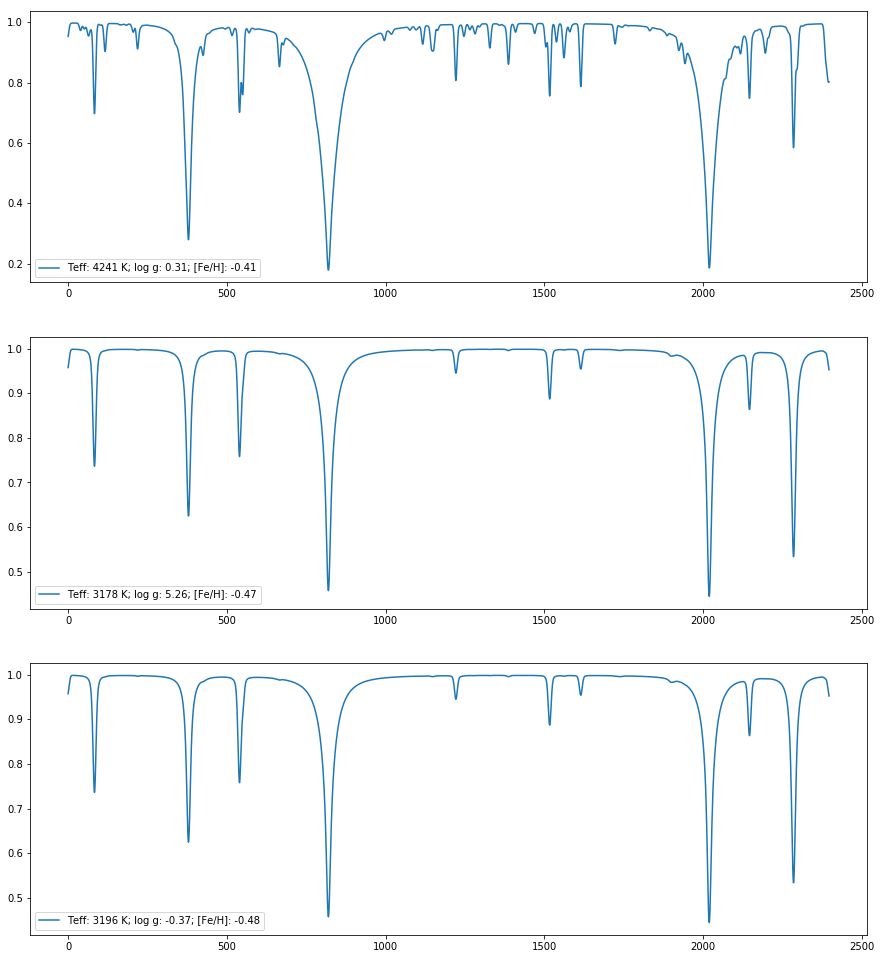

In [79]:
s = np.random.randint(low=0, high=len(labels), size=3)

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,17))
ax[0].plot(spectra[s[0]], label="Teff: {} K; log g: {}; [Fe/H]: {}".format(int(labels.teff[s[0]]), np.round(labels.logg[s[0]],2), np.round(labels.feH[s[0]],2)))
ax[1].plot(spectra[s[1]], label="Teff: {} K; log g: {}; [Fe/H]: {}".format(int(labels.teff[s[1]]), np.round(labels.logg[s[1]],2), np.round(labels.feH[s[1]],2)))
ax[2].plot(spectra[s[1]], label="Teff: {} K; log g: {}; [Fe/H]: {}".format(int(labels.teff[s[2]]), np.round(labels.logg[s[2]],2), np.round(labels.feH[s[2]],2)))
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()


## Standardization

In [80]:
columns = ['teff', 'logg', 'feH', 'vmic', 'vbroad', 'sife', 'cafe', 'tife',
       'mgfe', 'ndfe', 'sfe', 'zrfe', 'nfe', 'crfe', 'cefe', 'nife']
X = labels[columns]
scaler = preprocessing.StandardScaler().fit(X)
X_std = scaler.transform(X)


## Train/Test samples splitting

In [81]:
id_train, id_test, X_std_train, X_std_test, y_train, y_test = train_test_split(np.array(labels['runID']), X_std, spectra, test_size=0.2, random_state=42, shuffle=True)


In [82]:
print("Size training sample: {}".format(len(X_std_train)))
print("Size test sample: {}".format(len(X_std_test)))

Size training sample: 4000
Size test sample: 1000


## Define the model

In [83]:
shape_X = X_std_train.shape[1]
shape_y = y_train.shape[1]

#  input
input_layer = keras.layers.Input(shape=[shape_X])
# layer 1
L1 = keras.layers.Dense(100,kernel_initializer = 'he_normal')(input_layer)
L1a = tf.keras.layers.LeakyReLU(alpha=0.2)(L1)
# layer 2
L2 = keras.layers.Dense(100,kernel_initializer = 'he_normal')(L1a)
L2a = tf.keras.layers.LeakyReLU(alpha=0.2)(L2)
#  output
output = keras.layers.Dense(shape_y,kernel_initializer = 'he_normal')(L2a)

model = keras.models.Model(inputs=[input_layer], outputs=[output])

print(model.summary())

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 16)]              0         
_________________________________________________________________
dense_19 (Dense)             (None, 100)               1700      
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 2398)              242198    
Total params: 253,998
Trainable params: 253,998
Non-trainable params: 0
_______________________________________________

## Compile the model

In [84]:
loss = keras.losses.MeanAbsolutePercentageError()
optimizer = keras.optimizers.Adam(lr=0.005)
model.compile(loss=[loss], optimizer=optimizer)


## Train the model

In [85]:
model.fit(X_std_train, y_train, batch_size=100, epochs=50, verbose=1, validation_data=(X_std_test, y_test))
tr_cost = model.history.history['loss']
val_cost = model.history.history['val_loss']

Epoch 1/50
40/40 [==============================] - 0s 8ms/step - loss: 43.3026 - val_loss: 15.3018
Epoch 2/50
40/40 [==============================] - 0s 5ms/step - loss: 11.6138 - val_loss: 9.6304
Epoch 3/50
40/40 [==============================] - 0s 9ms/step - loss: 8.2112 - val_loss: 7.6556
Epoch 4/50
40/40 [==============================] - 0s 7ms/step - loss: 6.2155 - val_loss: 5.5925
Epoch 5/50
40/40 [==============================] - 0s 7ms/step - loss: 4.9172 - val_loss: 4.3770
Epoch 6/50
40/40 [==============================] - 0s 8ms/step - loss: 4.1400 - val_loss: 4.2407
Epoch 7/50
40/40 [==============================] - 0s 5ms/step - loss: 3.5538 - val_loss: 3.2755
Epoch 8/50
40/40 [==============================] - 0s 8ms/step - loss: 2.9744 - val_loss: 2.8199
Epoch 9/50
40/40 [==============================] - 0s 7ms/step - loss: 2.9627 - val_loss: 3.0120
Epoch 10/50
40/40 [==============================] - 0s 6ms/step - loss: 2.8567 - val_loss: 4.2825
Epoch 11/50
40/4

## Learning curve

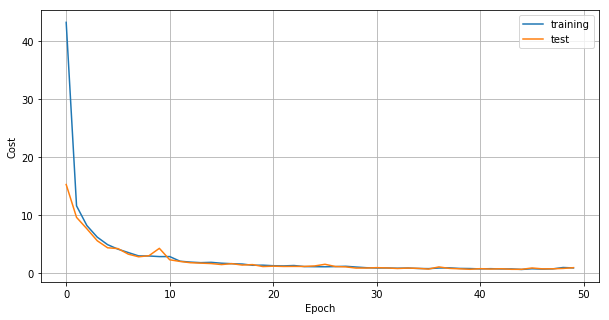

In [86]:


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
ax.plot(tr_cost, label='training')
ax.plot(val_cost, label='test')
ax.set_xlabel("Epoch")
ax.set_ylabel("Cost")
ax.set_ylabel("Cost")
#ax.set_xlim([0,100])
#ax.set_ylim([0,2])
ax.legend()
ax.grid()
plt.show()

## Inspect the results

Processing time: 0.05296588197234087 seconds


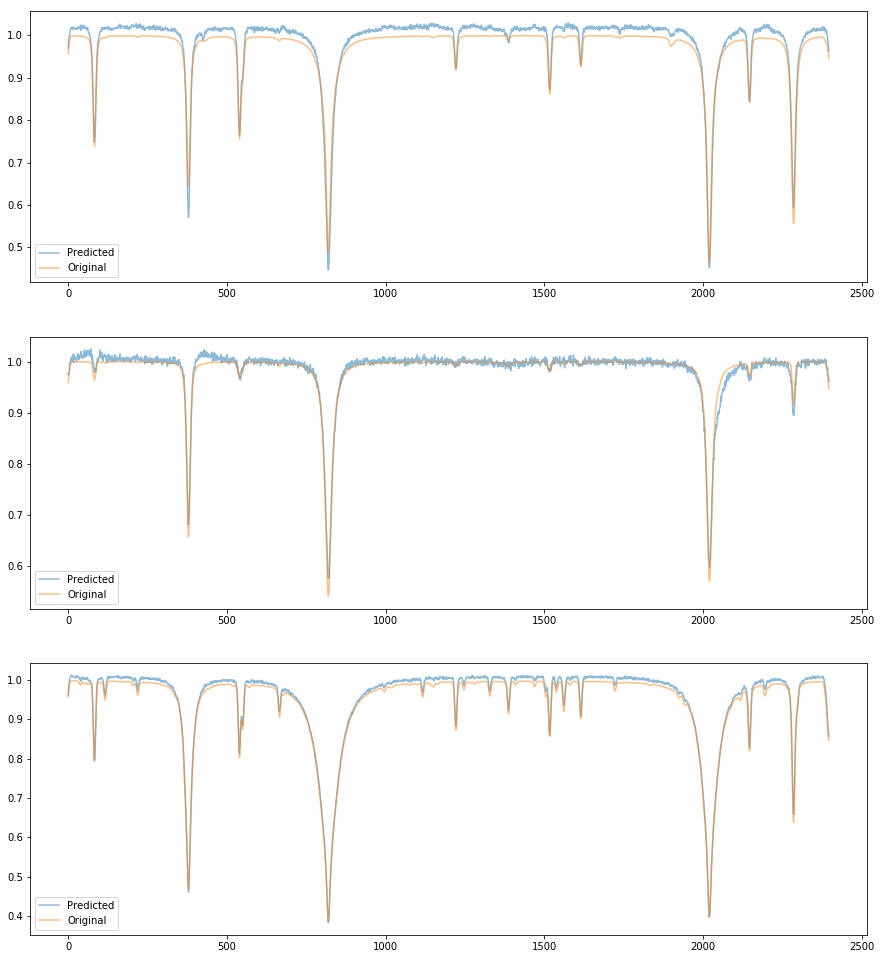

In [88]:
s = np.random.randint(low=0, high=len(X_std_test), size=3)
start = time.perf_counter()
pred_spectra = model.predict(X_std_test[s])
print("Processing time: {} seconds".format(time.perf_counter()-start))
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(15,17))
ax[0].plot(pred_spectra[0], alpha=0.5, label="Predicted")
ax[1].plot(pred_spectra[1], alpha=0.5, label="Predicted")
ax[2].plot(pred_spectra[2], alpha=0.5, label="Predicted")
ax[0].plot(y_test[s[0]], alpha=0.5, label="Original")
ax[1].plot(y_test[s[1]], alpha=0.5, label="Original")
ax[2].plot(y_test[s[2]], alpha=0.5, label="Original")
ax[0].legend()
ax[1].legend()
ax[2].legend()
plt.show()
